CIFAR10 dataset split into neg/pos and trained using normal CNN without augmentation.  
- Class weighting  

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/train/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "model": 'cnn',
    "ds_info": 'binary',
    "resample": False,
    "neg_class": ['ship'],
    "num_epochs": 10,
    "batch_size": 64,
    "img_shape": (32, 32, 3),
    "outcast": None,
    "optimizer": 'SGD',
    "learning_rate": 0.01,
    "early_stopping_patience": 10,
    "decay_rate": 0.4,              # higher number gives steeper dropoff
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

learning_rate = config["learning_rate"]
fine_tune_at = 130
fine_tune_epochs = 150
early_stopping_patience = config["early_stopping_patience"]

Create training, testing and validation dataset from utils/data_prep.py

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

Negative class names:
        - ship
Positive class names:
        - cat
        - airplane
        - deer
        - automobile
        - horse
        - truck
        - dog
        - bird
        - frog

Negative samples:  5000 | 10.00%
Positive samples: 45000 | 90.00%

Total number of images: 50000
Dataset.list_files:  /mnt/sdb/cifar10/train/*/*.*g 

[1 0 0 1 1 1 1 1 1 1]
[1 1 0 1 0 0 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 0 1 1 0 1]
[1 1 1 1 1 1 1 1 1 1]
[1 0 1 1 1 1 1 1 1 1]
[1 1 1 1 1 0 0 0 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]

Full dataset sample size:        50000
Train dataset sample size:       35000
Test dataset sample size:         7500
Validation dataset sample size:   7500


### Calculate class weights
See https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

In [ ]:
neg = params["neg_count"]
pos = params["pos_count"]
total = params["ds_size"]

weight_for_0 = (1/neg)*(total)/2.0
weight_for_1 = (1/pos)*(total)/2.0

class_weight = {0: weight_for_0,
                1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

# Training

### Normal CNN
See https://www.tensorflow.org/tutorials/images/cnn

In [4]:
from tensorflow.keras import datasets, layers, models
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

import datetime

In [5]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=config['img_shape']))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(params['num_classes'], activation='softmax'))

In [6]:
if config['verbosity'] > 0:
    cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          3

In [7]:
if config['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif config['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

cnn_model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
log_dir="./logs/{}/".format(config["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb]

In [9]:
history = cnn_model.fit(
    train_ds,
    steps_per_epoch = params["train_size"] // config["batch_size"],
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = params["test_size"] // config["batch_size"],
    validation_freq = 1
#     class_weight=class_weight
#     callbacks = callbacks
)

Train for 546 steps, validate for 117 steps
Epoch 1/10
546/546 [==============================] - 9s 16ms/step - loss: 0.2411 - accuracy: 0.9038 - val_loss: 0.1915 - val_accuracy: 0.9208
Epoch 2/10
546/546 [==============================] - 3s 5ms/step - loss: 0.1632 - accuracy: 0.9356 - val_loss: 0.1519 - val_accuracy: 0.9430
Epoch 3/10
546/546 [==============================] - 2s 5ms/step - loss: 0.1421 - accuracy: 0.9452 - val_loss: 0.1490 - val_accuracy: 0.9402
Epoch 4/10
546/546 [==============================] - 2s 5ms/step - loss: 0.1291 - accuracy: 0.9503 - val_loss: 0.1479 - val_accuracy: 0.9418
Epoch 5/10
546/546 [==============================] - 2s 5ms/step - loss: 0.1183 - accuracy: 0.9539 - val_loss: 0.1257 - val_accuracy: 0.9514
Epoch 6/10
546/546 [==============================] - 3s 5ms/step - loss: 0.1066 - accuracy: 0.9586 - val_loss: 0.1285 - val_accuracy: 0.9482
Epoch 7/10
546/546 [==============================] - 3s 5ms/step - loss: 0.0991 - accuracy: 0.9625 - v

`Keras`
Save/load the model

In [10]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Validate the results

In [11]:
cnn_evaluate = cnn_model.evaluate(val_ds, verbose=2, steps=params["val_size"] // config["batch_size"])

f = open(log_dir+"/evaluate.txt","w")
f.write( str(cnn_evaluate) )
f.close()

117/117 - 4s - loss: 0.1075 - accuracy: 0.9615


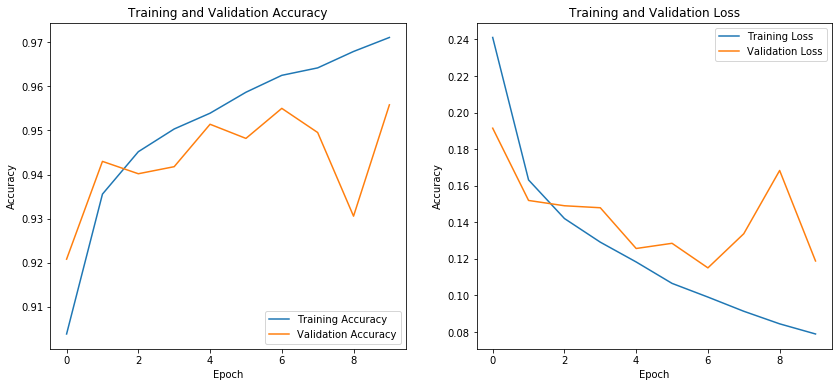

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(history.epoch[-1]+1)

plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

`Tensorboard`

## Predict new samples

In [13]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.0000 | Negative
1.0000 | Positive
Image 15 of 64


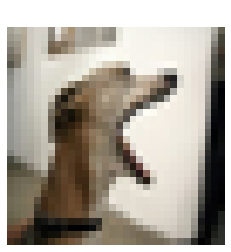

In [14]:
# Get a random image and label
rand = np.random.randint(0, config["batch_size"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = cnn_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions,):
    print("{:0.4f} | {}".format(pred, params["class_names"][i]))

prediction = ('Boat') if np.argmax(predictions)==0 else ('Not boat')

print ("Image {} of {}".format(rand, config["batch_size"]))

plt.figure(frameon=False, facecolor='white');
plt.title(prediction, fontdict={'color':'white','size':20})
plt.imshow(image)
plt.axis('off');

In [15]:
# Predict one batch
predictions = cnn_model.predict(images)

print ('{:3}  {:5}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -----  ----')

for i, pred in enumerate(predictions):
    label = params["class_names"][labels[i]][0:3]
    prediction = params["class_names"][np.argmax(pred)][0:3]
    print ('\n{:3}  {:5}  {:5}'.format(i, label, prediction), end='')
    if (label != prediction): print ("Wrong", end='')

idx  label  pred
---  -----  ----

  0  Pos    Pos  
  1  Pos    Pos  
  2  Pos    Pos  
  3  Pos    Pos  
  4  Pos    Pos  
  5  Neg    Pos  Wrong
  6  Pos    Pos  
  7  Pos    Pos  
  8  Neg    Pos  Wrong
  9  Pos    Pos  
 10  Pos    Pos  
 11  Pos    Pos  
 12  Pos    Pos  
 13  Pos    Pos  
 14  Pos    Pos  
 15  Pos    Pos  
 16  Pos    Pos  
 17  Pos    Pos  
 18  Pos    Pos  
 19  Pos    Pos  
 20  Pos    Pos  
 21  Pos    Pos  
 22  Pos    Pos  
 23  Pos    Pos  
 24  Pos    Pos  
 25  Pos    Pos  
 26  Pos    Pos  
 27  Pos    Pos  
 28  Pos    Pos  
 29  Pos    Pos  
 30  Pos    Pos  
 31  Pos    Pos  
 32  Pos    Pos  
 33  Pos    Pos  
 34  Pos    Pos  
 35  Pos    Pos  
 36  Pos    Pos  
 37  Pos    Pos  
 38  Pos    Pos  
 39  Pos    Pos  
 40  Pos    Pos  
 41  Pos    Pos  
 42  Pos    Pos  
 43  Pos    Pos  
 44  Pos    Pos  
 45  Pos    Pos  
 46  Pos    Pos  
 47  Pos    Pos  
 48  Pos    Pos  
 49  Pos    Pos  
 50  Pos    Pos  
 51  Pos    Pos  
 52  Pos    Pos  
 